<a href="https://colab.research.google.com/github/liuyao12/Ranger-Mish-ImageWoof-5/blob/master/Woof_128_new_ConvTwist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet with a Twist

> ConvTwist + Ranger + Mish + MaxBlurPool + restrick

# setup and imports

In [0]:
# pip install git+https://github.com/kornia/kornia

In [7]:
pip install git+https://github.com/ayasyrev/model_constructor

  Cloning https://github.com/ayasyrev/model_constructor to /tmp/pip-req-build-ng6nf3hh
  Running command git clone -q https://github.com/ayasyrev/model_constructor /tmp/pip-req-build-ng6nf3hh
  Created wheel for model-constructor: filename=model_constructor-0.1.1-cp36-none-any.whl size=21649 sha256=a7281a5680c8ff14f11e91aeb3b8d87693145735aa7e395f1b20f91c5615f45b
  Stored in directory: /tmp/pip-ephem-wheel-cache-3slrhgv1/wheels/5b/92/65/8093a307d5802f41f4a8776b40bc12b558e75a2a906ae8b683
Successfully built model-constructor


In [8]:
pip install git+https://github.com/ayasyrev/imagenette_experiments

  Cloning https://github.com/ayasyrev/imagenette_experiments to /tmp/pip-req-build-2inc6kud
  Running command git clone -q https://github.com/ayasyrev/imagenette_experiments /tmp/pip-req-build-2inc6kud
  Created wheel for imagenette-experiments: filename=imagenette_experiments-0.0.1-cp36-none-any.whl size=12379 sha256=656f64b58c623ef8901a911c94a86e99a67101b9151e3e1333422c14c20e701d
  Stored in directory: /tmp/pip-ephem-wheel-cache-c6pjhq9j/wheels/af/99/98/2212941f45a18bf6d191f56c39e3569138414560c76defc0d4
Successfully built imagenette-experiments


In [0]:
from imagenette_experiments.train_utils import *

In [0]:
from kornia.contrib import MaxBlurPool2d

In [0]:
from fastai.basic_train import *
from fastai.vision import *
# from fastai.script import *
from model_constructor.net import Net, act_fn
from model_constructor.layers import SimpleSelfAttention, ConvLayer

# Twist

In [0]:
class ConvTwist(nn.Module):  # replacing 3x3 Conv2d
    def __init__(self, ni, nf, stride=1, groups=1, iters=1):
        super(ConvTwist, self).__init__()
        self.twist = True
        self.same = ni==nf and stride==1
        if not (ni%groups==0 and nf%groups==0): groups = 1
        # elif ni%64==0: groups = ni//8
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=stride, padding=1, bias=False, groups=groups)
        if self.twist:
            # self.conv_x = nn.Conv2d(ni, nf, kernel_size=3, stride=stride, padding=1, bias=False, groups=groups)
            # self.conv_y = nn.Conv2d(ni, nf, kernel_size=3, stride=stride, padding=1, bias=False, groups=groups)
            std = self.conv.weight.std().item()
            self.coeff_Ax = nn.Parameter(torch.empty((nf,ni//groups)).normal_(0, std), requires_grad=True)
            self.coeff_Ay = nn.Parameter(torch.empty((nf,ni//groups)).normal_(0, std), requires_grad=True)
            # self.coeff_Bx = nn.Parameter(torch.zeros((nf,ni)).normal_(0, std), requires_grad=True)
            # self.coeff_By = nn.Parameter(torch.zeros((nf,ni)).normal_(0, std), requires_grad=True)
        self.iters = iters
        self.stride = stride
        self.groups = groups

    # def init_coeff(self):
    #     self.coeff_Bx.data = self.coeff_Ay
    #     self.coeff_By.data = -self.coeff_Ax

    def kernel(self, coeff_x, coeff_y):
        D_x = torch.Tensor([[-1,0,1],[-2,0,2],[-1,0,1]]).to(coeff_x.device)
        D_y = torch.Tensor([[1,2,1],[0,0,0],[-1,-2,-1]]).to(coeff_x.device)
        return coeff_x[:,:,None,None] * D_x + coeff_y[:,:,None,None] * D_y

    def full_kernel(self, kernel): # permuting the groups
        if self.groups==1: return kernel
        n = self.groups
        a,b,_,_ = kernel.size()
        a = a//n
        KK = torch.zeros((a*n,b*n,3,3)).to(kernel.device)
        KK[:a,-b:] = kernel[:a]
        for i in range(n):
            if i%4==0:
                KK[a*i:a*(i+1),b*(i+3):b*(i+4)] = kernel[a*i:a*(i+1)]
            else:
                KK[a*i:a*(i+1),b*(i-1):b*i] = kernel[a*i:a*(i+1)]
        return KK

    def _conv(self, inpt, kernel=None):
        permute = True
        if kernel is None:
            kernel = self.conv.weight
        if self.groups==1 or permute==False:
            return F.conv2d(inpt, kernel, padding=1, stride=self.stride, groups=self.groups)
        else:
            return F.conv2d(inpt, self.full_kernel(kernel), padding=1, stride=self.stride, groups=1)

    def symmetrize(self, conv_wt):
        # conv_wt.data = (conv_wt - conv_wt.flip(2).flip(3)) / 2
        if self.same:
            conv_wt.data = (conv_wt + torch.transpose(conv_wt,0,1)) / 2

    def forward(self, inpt):
        out = self._conv(inpt)
        if self.twist is False:
            return out
        _,_,h,w = out.size()
        XX = torch.from_numpy(np.indices((1,1,h,w))[3]*2/w-1).type(out.dtype).to(out.device) 
        YY = torch.from_numpy(np.indices((1,1,h,w))[2]*2/h-1).type(out.dtype).to(out.device)
        # self.symmetrize(self.conv_x.weight)
        # self.symmetrize(self.conv_y.weight)
        # kernel_x = self.conv_x.weight
        # kernel_y = self.conv_y.weight
        kernel_x = self.kernel(self.coeff_Ax, self.coeff_Ay)
        self.symmetrize(kernel_x)
        kernel_y = kernel_x.transpose(2,3).flip(3)  # make conv_y a 90 degree rotation of conv_x
        # kernel_y = self.kernel(self.coeff_Bx, self.coeff_By)
        out = out + XX * self._conv(inpt, kernel_x) + YY * self._conv(inpt, kernel_y)
        if self.same and self.iters>1:
            out = inpt + out / self.iters
            for _ in range(self.iters-1):
                out = out + (self._conv(out) + XX * self._conv(out, kernel_x) + YY * self._conv(out, kernel_y)) / self.iters
            out = out - inpt
        return out

# ResBlock

In [0]:
class NewLayer(nn.Sequential):
    """Basic conv layers block"""
    def __init__(self, ni, nf, ks=3, stride=1,
            act=True,  act_fn=nn.ReLU(inplace=True),
            bn_layer=True, bn_1st=True, zero_bn=False,
            padding=None, bias=False, groups=1, **kwargs):

        if padding==None: padding = ks//2
        if ks==3:  layers = [('ConvTwist', ConvTwist(ni, nf, stride=stride))]
        else: layers = [('Conv{}x{}'.format(ks,ks), 
                  nn.Conv2d(ni, nf, ks, stride=stride, padding=padding, bias=bias, groups=groups))]

        act_bn = [('act_fn', act_fn)] if act else []
        if bn_layer:
            bn = nn.BatchNorm2d(nf)
            nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
            act_bn += [('bn', bn)]
        if bn_1st: act_bn.reverse()
        layers += act_bn
        super().__init__(OrderedDict(layers))

In [0]:
class NewResBlock(Module):
    def __init__(self, expansion, ni, nh, stride=1,
                 conv_layer=ConvLayer, act_fn=act_fn, bn_1st=True,
                 pool=nn.AvgPool2d(2, ceil_mode=True), sa=False, sym=False, zero_bn=True):
        nf,ni = nh*expansion,ni*expansion
        conv_layer = NewLayer
        self.reduce = noop if stride==1 else pool
        layers  = [(f"conv_0", conv_layer(ni, nh, 3, act_fn=act_fn, bn_1st=bn_1st)),
                   (f"conv_1", conv_layer(nh, nf, 3, zero_bn=zero_bn, act=False, bn_1st=bn_1st))
        ] if expansion == 1 else [
                   (f"conv_0", conv_layer(ni, nh, 1, act_fn=act_fn, bn_1st=bn_1st)),
                   (f"conv_1", conv_layer(nh, nh, 3, act_fn=act_fn, bn_1st=bn_1st)),
                   (f"conv_2", conv_layer(nh, nf, 1, zero_bn=zero_bn, act=False, bn_1st=bn_1st))
        ]
        if sa: layers.append(('sa', SimpleSelfAttention(nf,ks=1,sym=sym)))
        self.convs = nn.Sequential(OrderedDict(layers))
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False, bn_1st=bn_1st)
        self.merge = act_fn

    def forward(self, x):
        o = self.reduce(x)
        return self.merge(self.convs(o) + self.idconv(o))

# Model Constructor

In [0]:
model = Net(c_out=10, layers=[3,4,6,3], expansion=4)
model.block = NewResBlock
# model.conv_layer = NewLayer # for the stem
pool = MaxBlurPool2d(3, True)
model.pool = pool
model.stem_pool = pool
model.stem_sizes = [3,32,64,64]
model.act_fn = Mish()
model.sa = True

# Runs and results



In [25]:
for _ in range(1):
    learn = get_learn(model=model, size=128, bs=32, mixup=0.5)
    learn.fit_fc(80, lr=4e-3, moms=(0.95,0.95), start_pct=0.72)

data path   /root/.fastai/data/imagewoof2
Learn path /root/.fastai/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.126184,1.900124,0.388649,0.846271,01:37
1,1.983501,1.727517,0.458641,0.889539,01:37
2,1.869737,1.525474,0.558157,0.931026,01:36
3,1.786551,1.448785,0.590481,0.934334,01:36
4,1.726128,1.366176,0.644184,0.941970,01:37
5,1.678314,1.246760,0.691270,0.955459,01:37
6,1.620222,1.246296,0.695851,0.957496,01:37
7,1.594413,1.191363,0.724612,0.961568,01:36
8,1.553412,1.187022,0.723339,0.969203,01:36
9,1.504044,1.090945,0.760499,0.968949,01:35


In [16]:
for _ in range(1):
    learn = get_learn(model=model, size=128, bs=32, mixup=0.5)
    learn.fit_fc(80, lr=4e-3, moms=(0.95,0.95), start_pct=0.72)

data path   /root/.fastai/data/imagewoof2
Learn path /root/.fastai/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.174184,1.920759,0.357852,0.845508,01:35
1,1.997055,1.762287,0.441079,0.894375,01:35
2,1.895067,1.564714,0.525834,0.914228,01:36
3,1.794292,1.440246,0.610588,0.936371,01:36
4,1.712571,1.328491,0.659710,0.950878,01:36
5,1.668134,1.268177,0.670654,0.955714,01:37
6,1.628677,1.221262,0.701960,0.960041,01:36
7,1.578143,1.178807,0.715958,0.961313,01:36
8,1.552206,1.150043,0.730975,0.963095,01:36
9,1.528476,1.098876,0.756681,0.961059,01:36


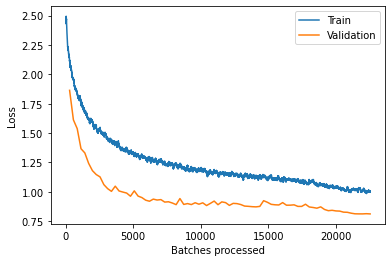

In [20]:
learn.recorder.plot_losses()

In [43]:
for _ in range(3):
    learn = get_learn(model=model, size=128, bs=32, mixup=0)
    learn.fit_fc(5, lr=4e-3, moms=(0.95,0.95), start_pct=0.72)

data path   /root/.fastai/data/imagewoof2
Learn path /root/.fastai/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.902802,1.813646,0.406719,0.886994,01:48
1,1.685970,1.553457,0.537032,0.928735,01:48
2,1.494283,1.428232,0.605498,0.944261,01:47
3,1.375602,1.260342,0.682871,0.955459,01:47
4,1.173522,1.112120,0.753627,0.970985,01:49


data path   /root/.fastai/data/imagewoof2
Learn path /root/.fastai/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.883435,1.821366,0.416645,0.876050,01:48
1,1.636686,1.559664,0.541868,0.924408,01:48
2,1.481322,1.386785,0.622805,0.946551,01:48
3,1.351673,1.243179,0.689234,0.960041,01:48
4,1.138180,1.096480,0.758463,0.973530,01:48


data path   /root/.fastai/data/imagewoof2
Learn path /root/.fastai/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.874111,1.813027,0.425554,0.892594,01:48
1,1.621625,1.545134,0.546449,0.925935,01:48
2,1.462013,1.387566,0.622805,0.942988,01:49
3,1.322632,1.246927,0.690252,0.959532,01:49
4,1.146231,1.085694,0.760499,0.975566,01:49


In [92]:
for name, param in learn.model.body.named_parameters():
    if 'ConvTwist' in name:
        print(name, param.size())

l_0.bl_0.convs.conv_1.ConvTwist.conv.weight torch.Size([64, 8, 3, 3])
l_0.bl_0.convs.conv_1.ConvTwist.conv_x.weight torch.Size([64, 8, 3, 3])
l_0.bl_0.convs.conv_1.ConvTwist.conv_y.weight torch.Size([64, 8, 3, 3])
l_0.bl_1.convs.conv_1.ConvTwist.conv.weight torch.Size([64, 8, 3, 3])
l_0.bl_1.convs.conv_1.ConvTwist.conv_x.weight torch.Size([64, 8, 3, 3])
l_0.bl_1.convs.conv_1.ConvTwist.conv_y.weight torch.Size([64, 8, 3, 3])
l_0.bl_2.convs.conv_1.ConvTwist.conv.weight torch.Size([64, 8, 3, 3])
l_0.bl_2.convs.conv_1.ConvTwist.conv_x.weight torch.Size([64, 8, 3, 3])
l_0.bl_2.convs.conv_1.ConvTwist.conv_y.weight torch.Size([64, 8, 3, 3])
l_1.bl_0.convs.conv_1.ConvTwist.conv.weight torch.Size([128, 8, 3, 3])
l_1.bl_0.convs.conv_1.ConvTwist.conv_x.weight torch.Size([128, 8, 3, 3])
l_1.bl_0.convs.conv_1.ConvTwist.conv_y.weight torch.Size([128, 8, 3, 3])
l_1.bl_1.convs.conv_1.ConvTwist.conv.weight torch.Size([128, 8, 3, 3])
l_1.bl_1.convs.conv_1.ConvTwist.conv_x.weight torch.Size([128, 8, 3, 3

In [1]:
for i in range(80):
    print('epoch {} {}'.format(i, learn.recorder.metrics[i][0].item()))

NameError: ignored

In [12]:
for i in range(80):
    print('epoch {} {}'.format(i, learn.recorder.metrics[i][0].item()))

epoch 0 0.3866123557090759
epoch 1 0.4499872624874115
epoch 2 0.5008907914161682
epoch 3 0.5970984697341919
epoch 4 0.6304402947425842
epoch 5 0.6688724756240845
epoch 6 0.6986510753631592
epoch 7 0.7327564358711243
epoch 8 0.7401374578475952
epoch 9 0.768134355545044
epoch 10 0.7643166184425354
epoch 11 0.7688979506492615
epoch 12 0.7673708200454712
epoch 13 0.7956222891807556
epoch 14 0.7930771112442017
epoch 15 0.814202070236206
epoch 16 0.8058030009269714
epoch 17 0.8180198669433594
epoch 18 0.8024942874908447
epoch 19 0.8170017600059509
epoch 20 0.8088572025299072
epoch 21 0.8198014497756958
epoch 22 0.8213285803794861
epoch 23 0.8187834024429321
epoch 24 0.8282005786895752
epoch 25 0.828964114189148
epoch 26 0.8261644244194031
epoch 27 0.8139475584030151
epoch 28 0.836090624332428
epoch 29 0.8332909345626831
epoch 30 0.8340544700622559
epoch 31 0.8345634937286377
epoch 32 0.833545446395874
epoch 33 0.8368541598320007
epoch 34 0.8381267786026001
epoch 35 0.8294731378555298
epoch 3

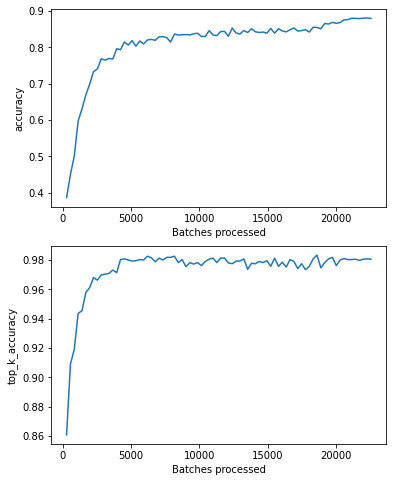

In [15]:
learn.recorder.plot_metrics()